# Overview of Content:

### mlo_04_correlations:


__Sections__:
- Main Module Import Section and Notebook Settings
- Initialize Custom Functions
- Read Notebook Variables
- Mauna Loa Auto-Correlation
- ONI Auto-Correlation
- Cross-Correlation: ONI x Mauna Loa (oeni x mmlo)


__Plot and Save Figures__:
- Mauna Loa Auto-Correlation:
    - autocorr_mmlo.pdf
    - autocorr_mmlo_detail.pdf
- ONI Auto-Correlation:
    - autocorr_oeni.pdf
- Cross-Correlation: ONI x Mauna Loa (oeni x mmlo):
    - crosscorr_oeni_mmlo.pdf
    - crosscorr_oeni_mmlo_detail.pdf

## Main Module Import Section and Notebook Settings

In [1]:
import numpy as np
import pandas as pd
from pandas.plotting import autocorrelation_plot
from datetime import datetime
from datetime import date
from datetime import timedelta
from scipy.fftpack import fft
from scipy import signal
from scipy.signal import butter, lfilter
import math
import matplotlib.pyplot as plt
%matplotlib notebook

plt.style.use('ggplot')
from matplotlib import rcParams
rcParams['lines.linewidth'] = 0.7
rcParams['figure.figsize'] = 9, 4.5
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

%config InlineBackend.figure_format = 'retina'

font = {'family': 'sans',
        'color':  'dimgrey',
        'weight': 'normal',
        'size': 12,
        }

import matplotlib

myred = '#E24A33'
myblue = '#348ABD'

## Initialize Custom Functions

In [2]:
def autocorr(x, norm=True, oneside=True):
    """
    returns auto-correlation values.
    norm: normalize correlation values
    oneside: returns only one side of auto-correlation
    """
    corr = np.correlate(x, x, mode='full')
    if norm == True:
        corr = corr / np.max(np.abs(corr))
    n = corr.size
    if oneside == True:
        corr = corr[int(np.floor(n/2)):]
    return corr

In [3]:
def confidence_corr(x, ci=95, z=False):
    """
    returns positive and negative confidence interval (ci) for auto-/cross-correlations
    and length of correlation lags
    ci[90 / 95 / 99]: ci value in %
    z: alternatively pass z-value
    """
    if z == False:
        if ci == 95:
            z = 1.96
        elif ci == 99:
            z = 2.56
        elif ci == 90:
            z = 1.65
    n = x.size
    return z / np.sqrt(n), -z / np.sqrt(n), n

In [4]:
def confidence_int(x, ci=95, z=False):
    """
    returns positive and negative confidence interval (ci)
    ci[90 / 95 / 99]: ci value in %
    z: alternatively pass z-value
    """
    if z == False:
        if ci == 95:
            z = 1.96
        elif ci == 99:
            z = 2.56
        elif ci == 90:
            z = 1.65
    n = x.size
    mean = np.mean(x)
    sigma = np.std(x, ddof=1)  # standard deviation for n-1 (ddof=1)
    h = sigma / np.sqrt(n)
    return z * h + mean, -z * h + mean

In [5]:
def plot_ci(data, interval='high', oneside=True):
    """
    plot confidence interval lines for an existing figure
    data: data array
    high: ci of 99% and 95%
    low: ci of 95% and 90%
    oneside=False: plot confidence interval for both sides (-data.size : + data.size)
    """
    if interval == 'high':
        x_high = confidence_corr(data, ci=99)
        label_high = '99% Vertrauensbereich'
        x_low = confidence_corr(data, ci=95)
        label_low = '95% Vertrauensbereich'
        
    elif interval == 'low':
        x_high = confidence_corr(data, ci=95)
        label_high = '95% Vertrauensbereich'
        x_low = confidence_corr(data, ci=90)
        label_low = '90% Vertrauensbereich'
        
    if oneside is True:
        x_min = 0
        x_max = x_high[2]
    elif oneside is False:
        x_max = x_high[2]
        x_min = - x_max

    plt.hlines(0, x_min, x_max, linestyles='solid', colors='k', label='')
    plt.hlines(x_high[0], x_min, x_max, linestyles='dashed', colors='k', label=label_high)
    plt.hlines(x_high[1], x_min, x_max, linestyles='dashed', colors='k')
    plt.hlines(x_low[0], x_min, x_max, linestyles='solid', colors='grey', label=label_low)
    plt.hlines(x_low[1], x_min, x_max, linestyles='solid', colors='grey')

## Read Notebook Variables

In [6]:
# read internal jupyter notebook variables

# stored via notebook: mlo_01_import.ipynb:
%store -r mmlo
%store -r oeni

# stored via notebook: mlo_02_merge_data.ipynb:
%store -r cut_a

## Mauna Loa Auto-Correlation

,mmlo_dec_date,mmlo_data
2017-02-28,2017.158904,406.42
2017-03-31,2017.243721,407.18
2017-04-30,2017.325913,409.00
2017-05-31,2017.410845,409.65
2017-06-30,2017.493037,408.84


<IPython.core.display.Javascript object>


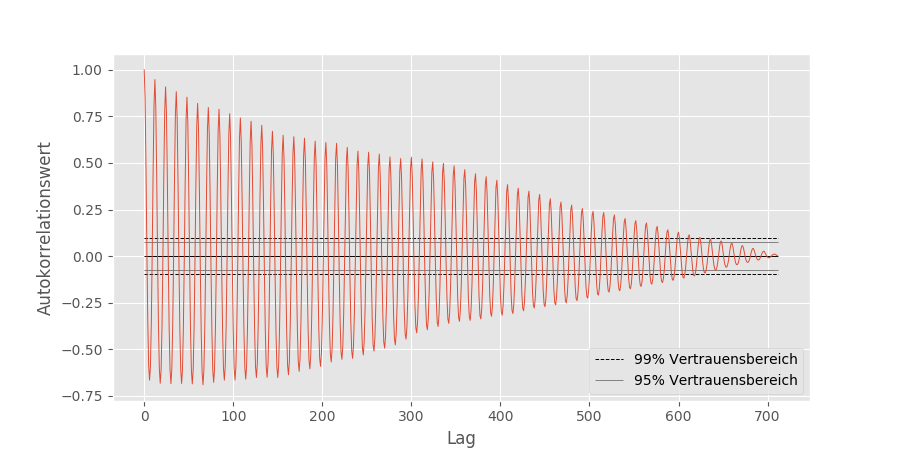

In [7]:
mmlo.loc[:, ['mmlo_dec_date', 'mmlo_data']].tail()
rcParams['figure.figsize'] = 9, 4.5
fig = plt.figure()
data = mmlo.mmlo_notrend
plt.plot(autocorr(data), color=myred, label='')
plot_ci(data)
plt.legend(loc='lower right')
plt.ylabel('Autokorrelationswert')
plt.xlabel('Lag')
plt.savefig('plots/autocorr_mmlo.pdf')

#### Mauna Loa Auto-Correlation: Detail

<IPython.core.display.Javascript object>


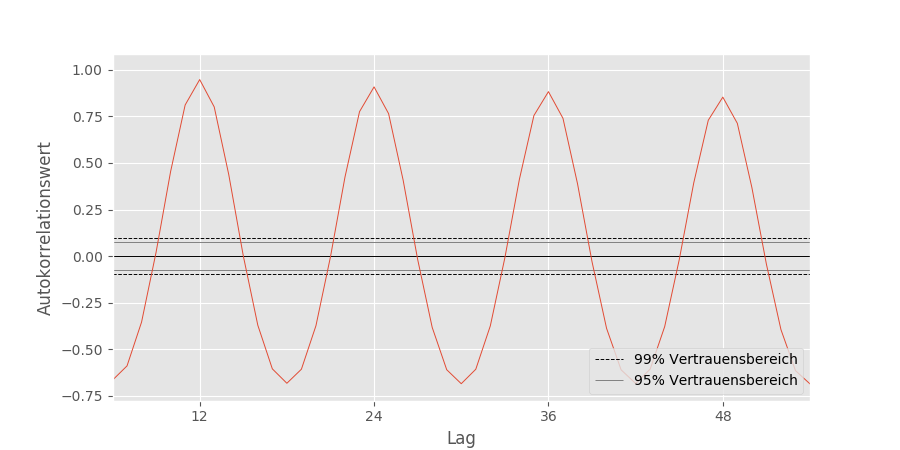

(6, 54)

([<matplotlib.axis.XTick at 0x11c52b9b0>,
 <a list of 4 Text xticklabel objects>)

In [8]:
fig = plt.figure()
data = mmlo.mmlo_notrend
plt.plot(autocorr(data), color=myred, label='')
plot_ci(data)
plt.xlim(6, 54)
plt.xticks(np.arange(12, 60, 12))
plt.legend(loc='lower right')
plt.ylabel('Autokorrelationswert')
plt.xlabel('Lag')
plt.savefig('plots/autocorr_mmlo_detail.pdf')

## ONI Auto-Correlation

,oeni_dec_date,oeni_data
2017-01-31,2017.082192,-0.42
2017-02-28,2017.158904,-0.12
2017-03-31,2017.243721,0.15
2017-04-30,2017.325913,0.39
2017-05-31,2017.410845,0.48


<IPython.core.display.Javascript object>


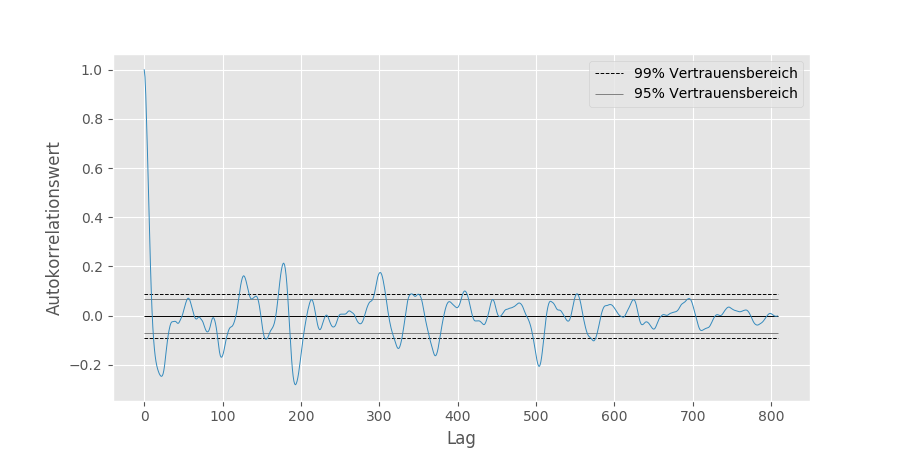

In [9]:
oeni.loc[:, ['oeni_dec_date', 'oeni_data']].tail()

fig = plt.figure()
data = oeni.oeni_data
plt.plot(autocorr(data), color=myblue, label='')
plot_ci(data)
plt.legend(loc='upper right')
plt.ylabel('Autokorrelationswert')
plt.xlabel('Lag')
plt.savefig('plots/autocorr_oeni.pdf')

## Cross-Correlation: ONI x Mauna Loa (oeni x mmlo)

,mmlo_dec_date,mmlo_notrend,oeni_data
2017-01-31,2017.082192,1.774619,-0.42
2017-02-28,2017.158904,1.890463,-0.12
2017-03-31,2017.243721,2.457734,0.15
2017-04-30,2017.325913,4.090799,0.39
2017-05-31,2017.410845,4.547453,0.48


<IPython.core.display.Javascript object>


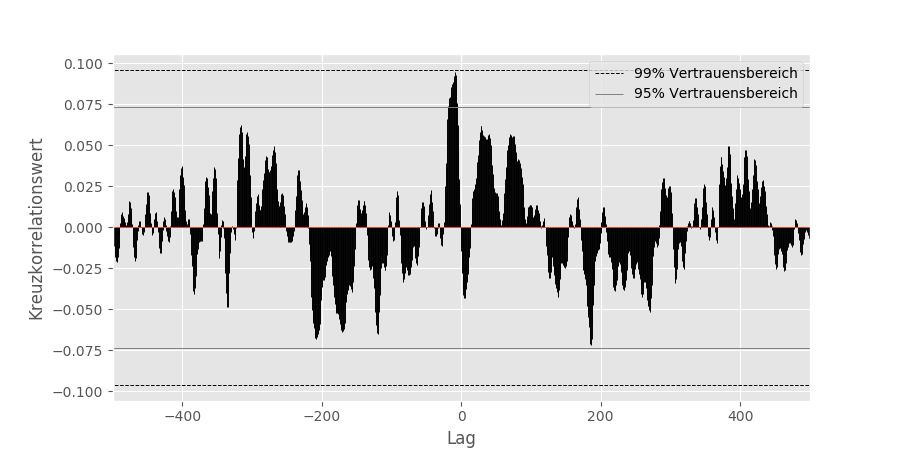

(array([-710, -709, -708, ...,  708,  709,  710]),
 array([ 0.00433135,  0.00695822,  0.00759702, ...,  0.00225525,
         0.00156888,  0.00050131]),
 <matplotlib.lines.Line2D at 0x11c7ecfd0>)

(-500, 500)

In [10]:
cut_a.loc[:, ['mmlo_dec_date', 'mmlo_notrend', 'oeni_data']].tail()
fig, ax = plt.subplots()
ax.xcorr(cut_a.oeni_data.values, cut_a.mmlo_notrend.values, normed=True, maxlags=None)
ax.set_ylabel('Kreuzkorrelationswert')
ax.set_xlabel('Lag')
xstart = -500
xstop = 500
plot_ci(cut_a.oeni_data.values, oneside=False)
plt.legend()
ax.set_xlim(xstart, xstop)
plt.savefig('plots/crosscorr_oeni_mmlo.pdf')

##### ONI x Mauna Loa Cross-Correlation (Lag 0 Detail)

<IPython.core.display.Javascript object>


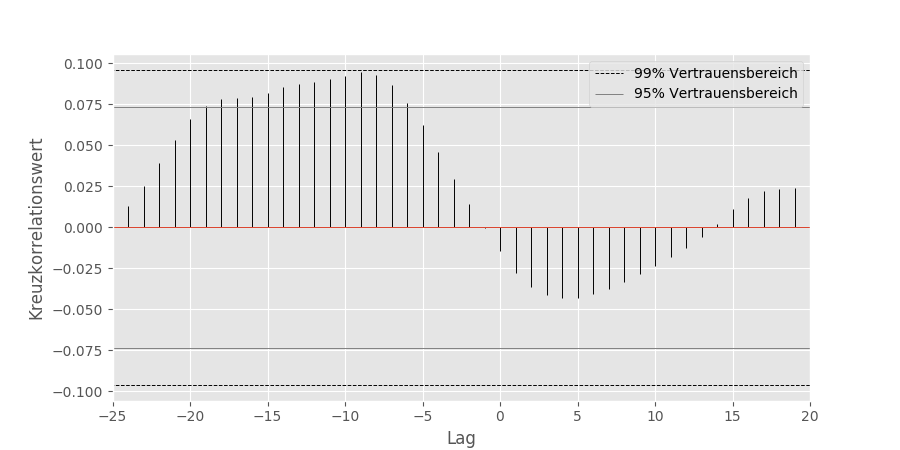

(array([-710, -709, -708, ...,  708,  709,  710]),
 array([ 0.00433135,  0.00695822,  0.00759702, ...,  0.00225525,
         0.00156888,  0.00050131]),
 <matplotlib.lines.Line2D at 0x11c9edda0>)

(-25, 20)

In [11]:
fig, ax = plt.subplots()
ax.xcorr(cut_a.oeni_data.values, cut_a.mmlo_notrend.values, normed=True, maxlags=None)
ax.set_ylabel('Kreuzkorrelationswert')
ax.set_xlabel('Lag')
xstart = -25
xstop = 20
plot_ci(cut_a.oeni_data.values, oneside=False)
ax.set_xlim(xstart, xstop)
plt.legend()
plt.savefig('plots/crosscorr_oeni_mmlo_detail.pdf')